In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.misc
import math
import matplotlib.pyplot as plt
import time

In [30]:
#используем готовую функцияю npy2cube
def npy2cube(grid, start, step, cube_f):
    '''
    PARAMETERS:
        grid : numpy array
            3-dimentional array, containing grid data
        start : tuple
            format: (x, y, z), coordinates of cube start point
        step: tuple
            format: (x, y, z), step size on 3 axes 
        cube_f: string
             name of output .cube file
    
    RETURNS:
        void    
    '''
    
    cube_string = ""
    bohr_to_angs = 0.529177210859 #const
    start = list(map(lambda x: x/bohr_to_angs, start))
    step = list(map(lambda x: x/bohr_to_angs, step))

    with open(cube_f, "w") as cube_file:
        ###HEADER###
        cube_file.write(" CPMD CUBE FILE.\nOUTER LOOP: X, MIDDLE LOOP: Y, INNER LOOP: Z\n")
        cube_file.write("    1 %f %f %f\n" %(start[0], start[1], start[2]))
        cube_file.write("  %i    %f   0.000000     0.000000\n" %(grid.shape[0], step[0]))
        cube_file.write("  %i    0.000000    %f    0.000000\n" %(grid.shape[1], step[1]))
        cube_file.write("  %i    0.000000    0.000000    %f\n" %(grid.shape[2], step[2]))
        cube_file.write("    1    0.000000    %f %f %f\n" %(start[0], start[1], start[2]))

        ###DATA###
        i = 0
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                for z in range(grid.shape[2]):
                    if i < 5:
                        cube_file.write("%f " %(float(grid[x, y, z])))
                        i += 1
                    elif i == 5:
                        cube_file.write("%f\n" %(float(grid[x, y, z])))
                        i = 0
    return 0    
    
    
# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser(description = "Convert .npy to .cube file")
#     parser.add_argument("-npy", help = "Input .npy filename")
#     parser.add_argument("-cube", help = "Output .cube filename")
#     parser.add_argument("-start", type = float, nargs = 3, help = "Coordinates of cube start point")
#     parser.add_argument("-step", type = float, nargs = 3, help = "Step between nodes in grid on each axe, Angstremes")
#     args = parser.parse_args()
#     grid = np.load(args.npy)
#     npy2grid(grid, args.start, args.step, args.cube)

##### Запишем функцию для расчета волновой функции 

In [35]:
def w(n,l,m,d):
    #n,l,m – квантовые числа
    #d – шаг
    
    #координаты в декартовой системе (30*30*30)
    x,y,z = np.mgrid[-d:d:30j,-d:d:30j,-d:d:30j]
    
    #переход к сферическим координатам, r – радиус дистанции, thata, phi – углы относительно осей
    r = lambda x,y,z: np.sqrt(x**2+y**2+z**2)
    theta = lambda x,y,z: -np.arcsin(z/r(x,y,z)) + math.pi/2
    phi = lambda x,y,z: np.arctan2(y, x) + math.pi
    
    #боровский радиус, наиболее вероятная дистанция между ядром и электроном
    a0 = 1
    
    #R – радиальная часть волновой функции, n, l – квантовые числа
    R = lambda r,n,l: (2*r/n/a0)**l * np.exp(-r/n/a0) * scipy.special.genlaguerre(n-l-1,2*l+1)(2*r/n/a0)
    
    #добавочный коэффициент
    k = lambda n,l: np.sqrt((2/n/a0)**3 * math.factorial(n-l-1)/(2*n*math.factorial(n+l)))
    
    #волновая функция
    WF = lambda r,theta,phi,n,l,m: k(n, l) * R(r,n,l) * scipy.special.sph_harm(m,l,phi,theta)
    
    #плотность вероятности WF
    absWF = lambda r,theta,phi,n,l,m: np.absolute(WF(r,theta,phi,n,l,m))**2
    
    result = WF(r(x,y,z),theta(x,y,z),phi(x,y,z),n,l,m)
    
    return np.real(result) + np.imag(result)

#####  Посчитаем значения для первых трех уровней орбиталей

In [39]:
for n in range(1, 4):
    d = 7 * n
    step = 2 * d / 29
    for l in range(0, n):
        for m in range(-l, l+1):
            grid = w(n, l, m, d)
            name = f'{n}-{l}-{m}'
            npy2cube(grid, (-d,)*3, (step,)*3, f'{name}.cube')

##### А теперь посмотрим, что насчиталось в Pymol

In [22]:
from xmlrpc.client import ServerProxy
from pymol import cmd,stored
cmd = ServerProxy(uri='http://localhost:9123/RPC2')

In [61]:
out = open ('volume_color.pml', 'w')

out.write('cmd.volume_ramp_new(\'ramp007\', [\
     -0.015, 1.00, 0.00, 0.00, 0.00, \
      -0.01,  1.00, 1.00, 0.00, 0.20, \
      -0.005, 0.00, 0.00, 1.00, 0.00, \
      0.005, 0.00, 0.00, 1.00, 0.00, \
      0.01,  0.00, 1.00, 1.00, 0.20, \
      0.015, 0.00, 0.00, 1.00, 0.00, \
    ])\n')

for n in range(0,4):
    for l in range(0,n):
        for m in range(-1,l+1,1):
            name='%s-%s-%s' % (n,l,m)
            lname = "/Users/ann/Documents/" + name+'.cube'
            vname = name+'_vol'
            out.write('load %s, %s\n' % (lname, name))
            out.write('volume %s, %s\n' % (vname, name))
            out.write('volume_color %s, ramp007\n' % (vname))
out.close()

In [62]:
cmd.load("/Users/ann/Documents/volume_color.pml")

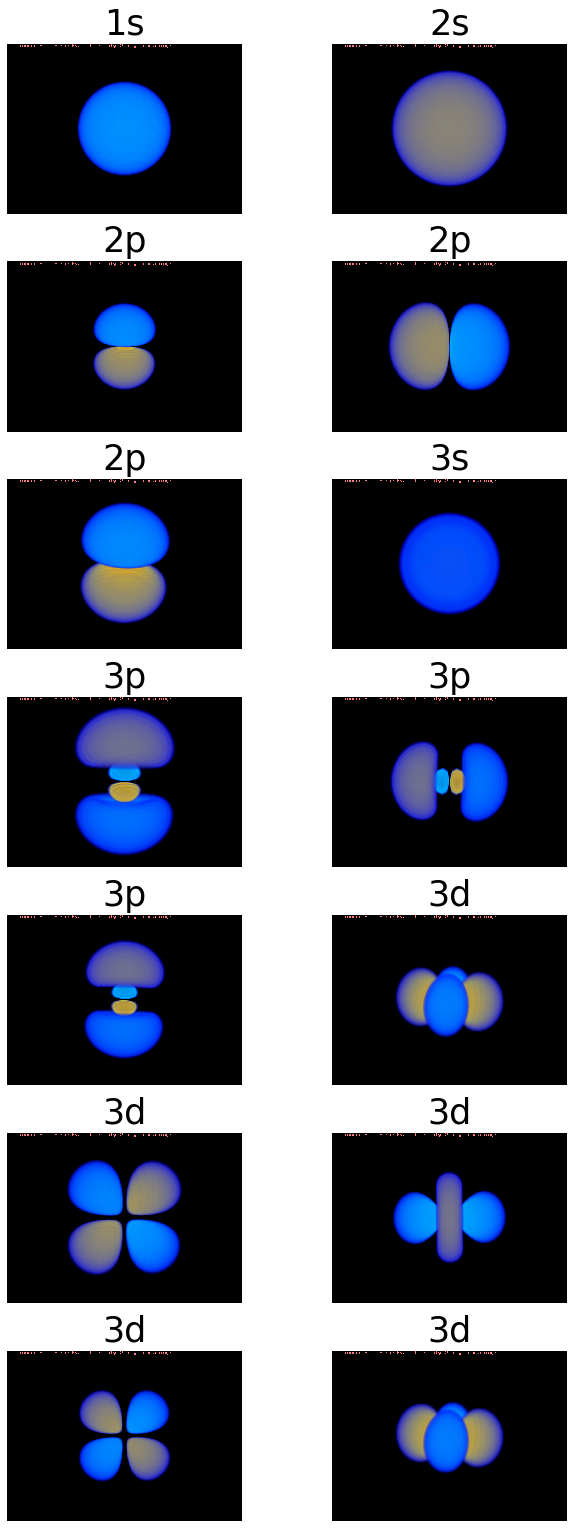

In [71]:
orbitales = {0: 's', 1: 'p', 2: 'd'}

_, axarr = plt.subplots(7, 2, figsize=(10, 21.33)) #будет 7 строк по 2 столбца с изображениями

row, col = 0, 0
for n in range(1, 4):
    for l in range(0, n):
        for m in range(-l, l+1):
            name = f'{n}-{l}-{m}'
            f = plt.imread(f'{name}.png')
            axarr[row, col].axis('off')
            axarr[row, col].imshow(f)
            axarr[row, col].set_title(f'{n}{orbitales[l]}',
                                      {'fontsize': 35}, pad=10)
            col += 1
            if col == 2:
                row += 1
                col = 0
plt.tight_layout()

##### Выглядит правдоподобно

### Визуализируем орбитали с помощью расчетов Orca

In [73]:
#Создаем файл для дальнейших расчетов 
with open('h.inp', 'w') as f:
    f.write('''! UHF QZVPP XYZFile
%plots Format Cube
MO("H-0.cube",0,0);
MO("H-1.cube",1,0);
MO("H-2.cube",2,0);
MO("H-3.cube",3,0);
MO("H-4.cube",4,0);
MO("H-5.cube",5,0);
MO("H-6.cube",6,0);
MO("H-7.cube",7,0);
MO("H-8.cube",8,0);
MO("H-9.cube",9,0);
MO("H-10.cube",10,0);
MO("H-11.cube",11,0);
MO("H-12.cube",12,0);
MO("H-13.cube",13,0);
end
* xyz 0 2
H 0 0 0
* ''')

##### Запускаем orca на kodomo

In [ ]:
# export PATH=${PATH}:/srv/databases/orca
# orca h.inp

##### Посмотрим в Pymol

In [82]:
out = open ('volume_color.pml', 'w')

out.write('cmd.volume_ramp_new(\'ramp009\', [\
     -0.015, 1.00, 0.00, 0.00, 0.00, \
      -0.01,  1.00, 1.00, 0.00, 0.20, \
      -0.005, 0.00, 0.00, 1.00, 0.00, \
      0.005, 0.00, 0.00, 1.00, 0.00, \
      0.01,  0.00, 1.00, 1.00, 0.20, \
      0.015, 0.00, 0.00, 1.00, 0.00, \
    ])\n')

for file in range(14):
    name='%s-%s' % ('H', file)
    lname = "/Users/ann/Documents/" +name+'.cube'
    vname = name+'_vol'
    out.write('load %s, %s\n' % (lname, name))
    out.write('volume %s, %s\n' % (vname, name))
    out.write('volume_color %s, ramp007\n' % (vname))
out.close()

In [83]:
cmd.load("/Users/ann/Documents/volume_color.pml")

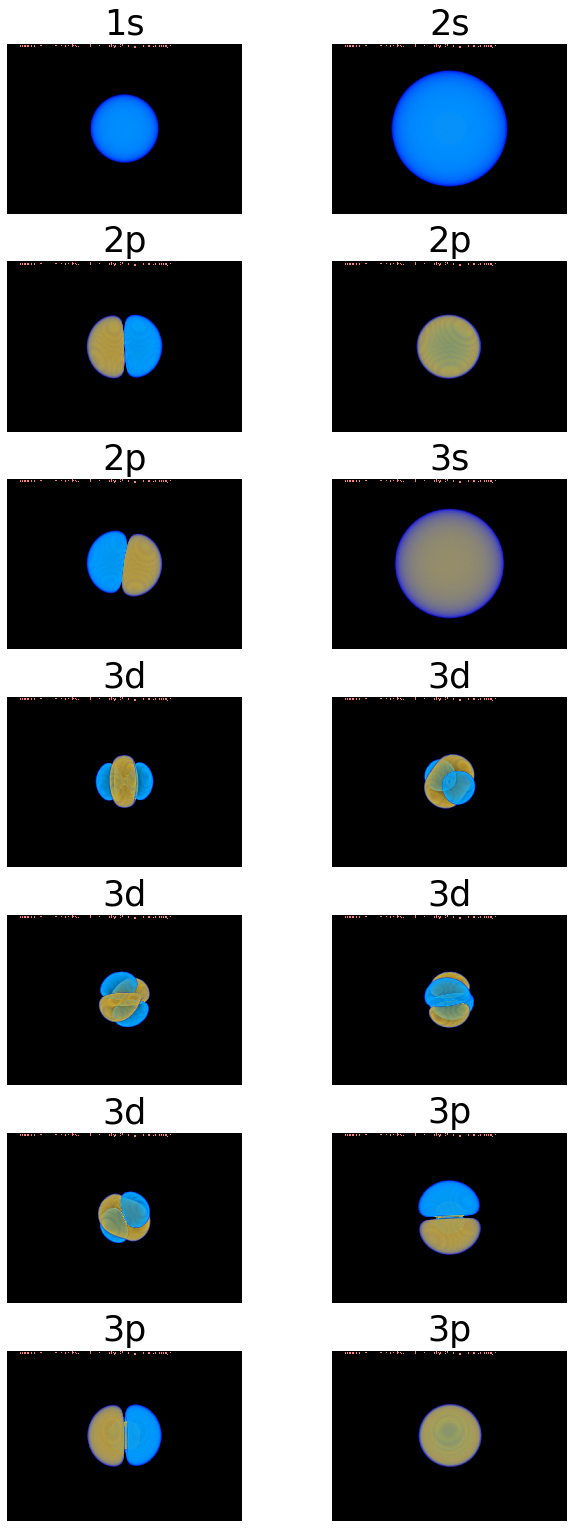

In [84]:
orbitales = ['1s', '2s', '2p', '2p', '2p', '3s', '3d', '3d', '3d', '3d', '3d', '3p', '3p', '3p']
orbitales = (n for n in orbitales)

_, axarr = plt.subplots(7, 2, figsize=(10, 21.33))

row, col = 0, 0
for n in range(14):
    name = f'H-{n}png'
    f = plt.imread(f'{name}.png')
    axarr[row, col].axis('off')
    axarr[row, col].imshow(f)
    axarr[row, col].set_title(f'{next(orbitales)}', {'fontsize': 35}, pad=10)
    col += 1
    if col == 2:
        row += 1
        col = 0
plt.tight_layout()

##### В целом выглядит довольно похоже на рассчитанные вручную. Однако тут формы чуть более сложные. Вероятно, более правдоподобные.